In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
import math

In [86]:
# read in all the files from the results folder
datasource = "function"
dataname = "parkinsons"
# dataname = "ccle"
seed = np.arange(1, 21)
task = "regression"
data_type = "test"
methods = ['shap', 'signed_normalized_l2_avg', 'signed_normalized_l2_noavg',
           'signed_nonnormalized_l2_avg', 'signed_nonnormalized_l2_noavg',
           'nonl2_avg', 'nonl2_noavg', 'l2_ranking', 'nonl2_ranking', 'baseline']
p_values = [0.1, 0.3, 0.5, 0.7, 0.9]
p_values = list(map(str, p_values))
values_results = {}
# rankings_results = {}
task_results = {}
for i in range(len(seed)):
    values_dict = {}
    rankings_dict = {}
    for method in methods:
        file = f"results/{data_type}_data/{datasource}_{dataname}_seed{seed[i]}_{method}_values.csv"
        values_dict[method] = pd.read_csv(file)
        # for p_value in p_values:
        #     if method == 'normalized_l2_ranking':
        #         continue
        #     file = f"results/{data_type}_data/{datasource}_{dataname}_seed{seed[i]}_{method}_{p_value}_ranking.csv"
        #     rankings_dict[method + "_" + p_value] = pd.read_csv(file)
    values_results[datasource + "_" + dataname + "_" + str(seed[i])] = values_dict
    # rankings_results[datasource + "_" + dataname + "_" + str(seed[i])] = rankings_dict
    task_results[datasource + "_" + dataname + "_" + str(seed[i])] = task

In [87]:
auc_dict = {}
auc_top_ten_percent = {}
viz_methods = ['shap', 'signed_nonnormalized_l2_noavg']
# metrics = ['AUROC', 'AUPRC', 'R^2', 'F1', 'Accuracy']
metrics = ["R^2"]
for metric in metrics:
    metric_aucs = {}
    metric_top_ten_aucs = {}
    for method in methods:
        aucs_per_seed = []
        aucs_top_ten = []
        for s in seed:
            datastring = datasource + "_" + dataname + "_" + str(s)
            vec = values_results[datastring][method].loc[:, metric]
            vec_len = vec.shape[0]
            aucs_per_seed.append(np.trapz(vec)/vec_len)
            aucs_top_ten.append(np.trapz(vec[:int(vec_len * 0.1)])/vec[:int(vec_len * 0.1)].shape[0])
        aucs_per_seed = np.array(aucs_per_seed)
        aucs_top_ten = np.array(aucs_top_ten)
        metric_aucs[method] = aucs_per_seed.mean()
        metric_top_ten_aucs[method] = aucs_top_ten.mean()
    auc_dict[metric] = metric_aucs
    auc_top_ten_percent[metric] = metric_top_ten_aucs
aucs = pd.DataFrame(auc_dict)
aucs_top_ten = pd.DataFrame(auc_top_ten_percent)
aucs_top_ten = aucs_top_ten.sort_values(by=metrics[0], ascending=False)
# sort rows in aucs by highest auroc
aucs = aucs.sort_values(by=metrics[0], ascending=False)

In [88]:
aucs

,R^2
shap,0.979945
nonl2_noavg,0.976133
nonl2_avg,0.976062
signed_normalized_l2_avg,0.970099
signed_normalized_l2_noavg,0.969062
signed_nonnormalized_l2_avg,0.969018
signed_nonnormalized_l2_noavg,0.968276
baseline,0.958817
nonl2_ranking,0.805122
l2_ranking,0.802941


In [89]:
aucs_top_ten

,R^2
shap,0.885977
nonl2_noavg,0.859008
nonl2_avg,0.854468
signed_normalized_l2_avg,0.819575
signed_normalized_l2_noavg,0.817748
signed_nonnormalized_l2_avg,0.811027
signed_nonnormalized_l2_noavg,0.808602
baseline,0.735191
nonl2_ranking,0.386716
l2_ranking,0.371979


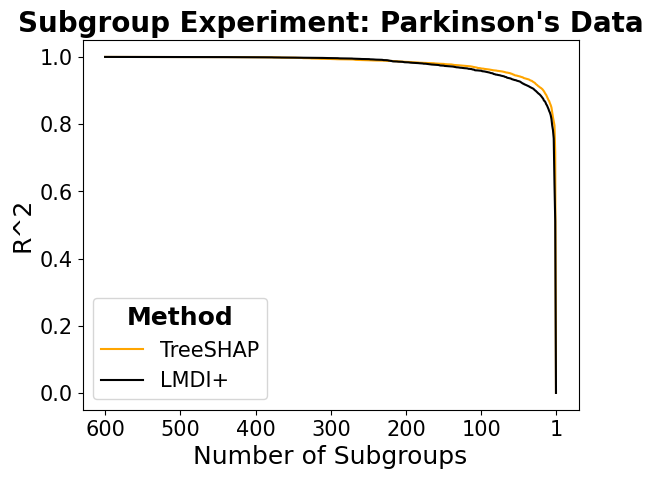

In [93]:
auc_dict = {}
# metrics = ['AUROC', 'AUPRC', 'R^2', 'F1', 'Accuracy']
metrics = ["R^2"]
viz_methods = ['shap', 'nonl2_noavg']
method_names = {'shap': 'TreeSHAP', 'nonl2_noavg': 'LMDI+'}
method_colors = {'shap': 'orange', 'nonl2_noavg': 'black'}
for metric in metrics:
    metric_aucs = {}
    for method in viz_methods:
        max_num = 0
        for s in seed:
            if values_results[datasource + "_" + dataname + "_" + str(s)][method].loc[:, metric].to_numpy().flatten().shape[0] > max_num:
                max_num = values_results[datasource + "_" + dataname + "_" + str(s)][method].loc[:, metric].to_numpy().flatten().shape[0]
        aucs_per_seed = np.empty((len(seed), max_num))
        for s in seed:
            # print(values_results[datasource + "_" + dataname + "_" + str(s)][method].loc[:, metric])
            # if values_results[datasource + "_" + dataname + "_" + str(s)][method].loc[:, metric].to_numpy().flatten().shape[0] < max_num, repeat the last element to fill out space
            if values_results[datasource + "_" + dataname + "_" + str(s)][method].loc[:, metric].to_numpy().flatten().shape[0] < max_num:
                results = np.pad(values_results[datasource + "_" + dataname + "_" + str(s)][method].loc[:, metric].to_numpy().flatten(), (0, max_num - values_results[datasource + "_" + dataname + "_" + str(s)][method].loc[:, metric].to_numpy().flatten().shape[0]), 'edge')
            else:
                results = values_results[datasource + "_" + dataname + "_" + str(s)][method].loc[:, metric].to_numpy().flatten()
            aucs_per_seed[s - 1, :] = results
        aucs_per_seed = np.array(aucs_per_seed)
        metric_aucs[method] = aucs_per_seed.mean(axis=0)
    auc_dict[metric] = metric_aucs
auc_dict

for metric, method_dict in auc_dict.items():
    for method, vec in method_dict.items():
        plt.plot(np.arange(vec.shape[0]), vec, label=method_names[method], color = method_colors[method])
        # plt.plot(np.arange(vec.shape[0]), vec, label = method)
    plt.xticks([0, 99, 199, 299, 399, 499, 599], ["1", "100", "200", "300", "400", "500", "600"])
    plt.xlabel("Number of Subgroups", fontsize=18)
    # make xaxis label big
    plt.tick_params(axis='both', labelsize=15)
    # y-axis label should be Average Ranking
    plt.ylabel("R^2", fontsize=18)
    plt.title("Subgroup Experiment: Parkinson's Data", fontsize=20, fontweight='bold')
    title_font_properties = font_manager.FontProperties(weight='bold', size=18)
    plt.legend(title = "Method", fontsize=15, title_fontproperties = title_font_properties)
    # plt.legend()
    plt.gca().invert_xaxis()
    plt.show()

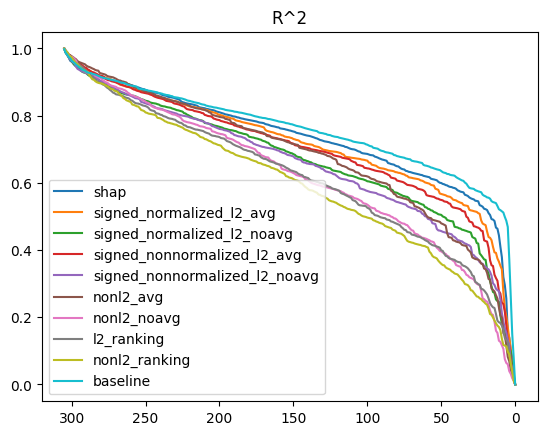

In [18]:
auc_dict = {}
# metrics = ['AUROC', 'AUPRC', 'R^2', 'F1', 'Accuracy']
metrics = ["R^2"]
p = 0.9
for metric in metrics:
    metric_aucs = {}
    for method in methods:
        max_num = 0
        for s in seed:
            if rankings_results[datasource + "_" + dataname + "_" + str(s)][method + "_" + str(p)].loc[:, metric].to_numpy().flatten().shape[0] > max_num:
                max_num = rankings_results[datasource + "_" + dataname + "_" + str(s)][method + "_" + str(p)].loc[:, metric].to_numpy().flatten().shape[0]
        aucs_per_seed = np.empty((len(seed), max_num))
        for s in seed:
            if rankings_results[datasource + "_" + dataname + "_" + str(s)][method + "_" + str(p)].loc[:, metric].to_numpy().flatten().shape[0] < max_num:
                results = np.pad(rankings_results[datasource + "_" + dataname + "_" + str(s)][method + "_" + str(p)].loc[:, metric].to_numpy().flatten(), (0, max_num - rankings_results[datasource + "_" + dataname + "_" + str(s)][method + "_" + str(p)].loc[:, metric].to_numpy().flatten().shape[0]), 'edge')
            else:
                results = rankings_results[datasource + "_" + dataname + "_" + str(s)][method + "_" + str(p)].loc[:, metric].to_numpy().flatten()
            aucs_per_seed[s - 1, :] = results
        aucs_per_seed = np.array(aucs_per_seed)
        metric_aucs[method] = aucs_per_seed.mean(axis=0)
    auc_dict[metric] = metric_aucs
auc_dict

for metric, method_dict in auc_dict.items():
    for method, vec in method_dict.items():
        plt.plot(np.arange(vec.shape[0]), vec, label=method)
    plt.legend()
    plt.gca().invert_xaxis()
    plt.title(metric)
    plt.show()

In [19]:
auc_dict = {}
# metrics = ['AUROC', 'AUPRC', 'R^2', 'F1', 'Accuracy']
metrics = ["R^2"]
for metric in metrics:
    metric_aucs = {}
    for method in methods:
        for p in p_values:
            aucs_per_seed = []
            for s in seed:
                aucs_per_seed.append(np.trapz(rankings_results[datasource + "_" + dataname + "_" + str(s)][method + "_" + str(p)].loc[:, metric])/values_results[datasource + "_" + dataname + "_" + str(s)][method].shape[0])
            aucs_per_seed = np.array(aucs_per_seed)
            metric_aucs[method + "_" + p] = aucs_per_seed.mean()
    auc_dict[metric] = metric_aucs
aucs = pd.DataFrame(auc_dict)
# sort rows in aucs by highest auroc
aucs = aucs.sort_values(by=metrics[0], ascending=False)
aucs

,R^2
baseline_0.9,0.753399
shap_0.9,0.730412
signed_normalized_l2_avg_0.9,0.713246
signed_nonnormalized_l2_avg_0.9,0.697899
nonl2_avg_0.9,0.677963
signed_normalized_l2_noavg_0.9,0.666488
signed_nonnormalized_l2_noavg_0.9,0.654051
nonl2_noavg_0.9,0.618623
l2_ranking_0.9,0.615348
nonl2_ranking_0.9,0.593878


Results for dataset temperature from datasource function with seed 1.


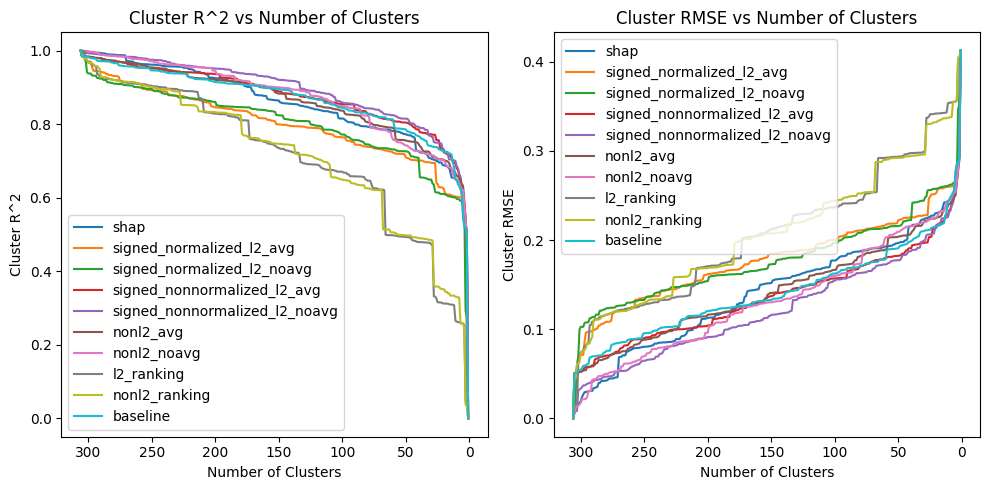

Results for dataset temperature from datasource function with seed 2.


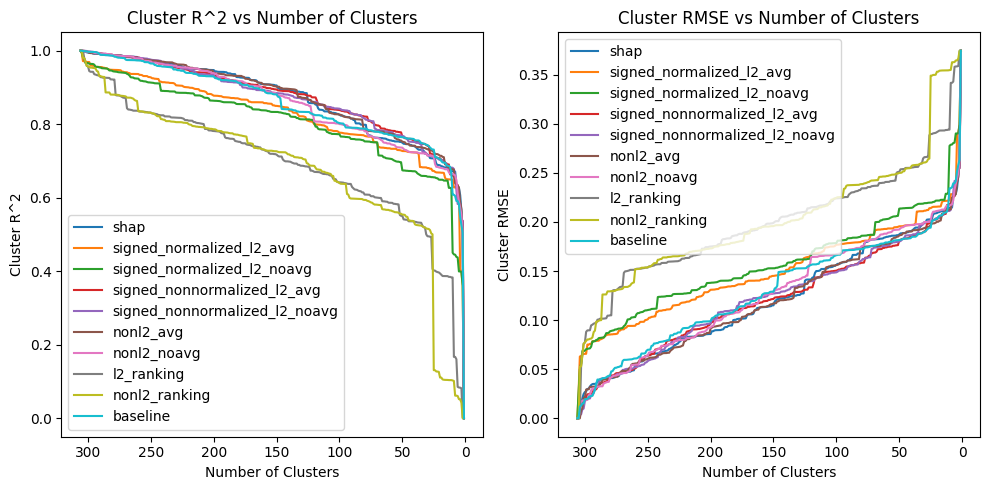

Results for dataset temperature from datasource function with seed 3.


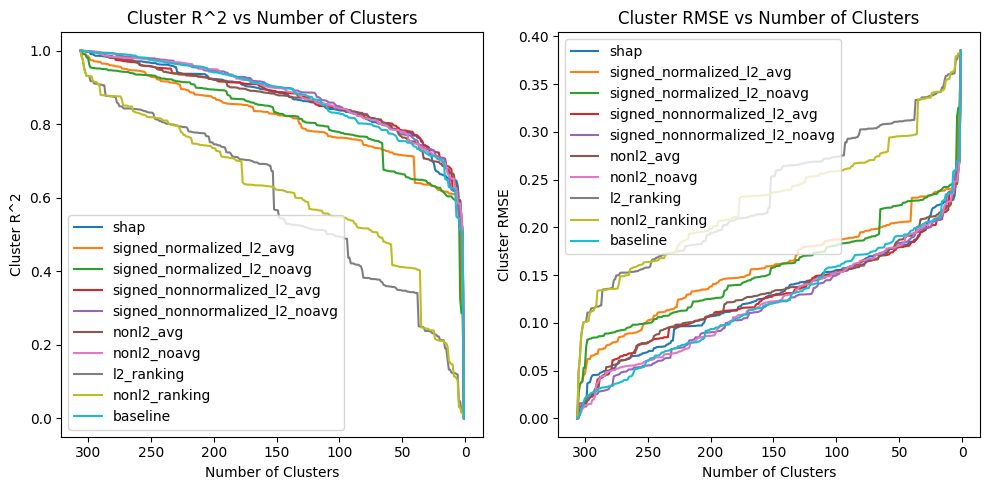

Results for dataset temperature from datasource function with seed 4.


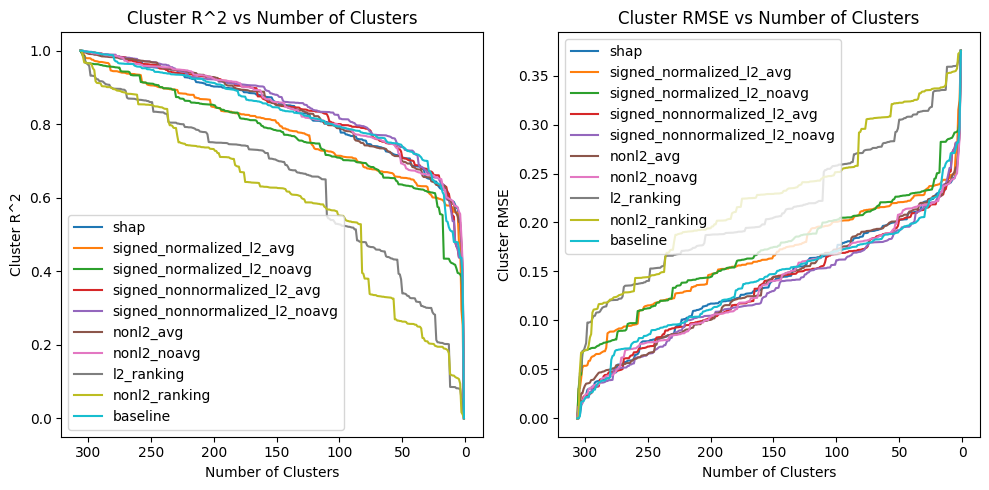

Results for dataset temperature from datasource function with seed 5.


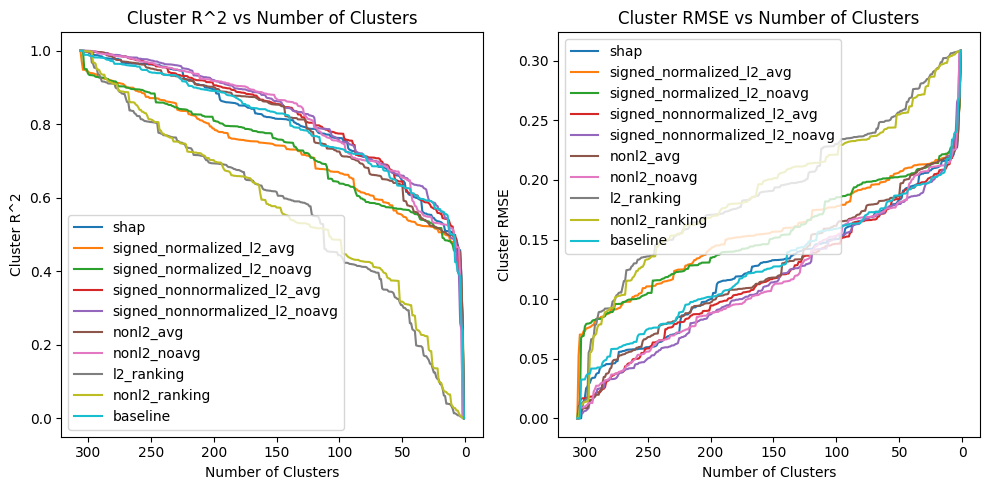

Results for dataset temperature from datasource function with seed 6.


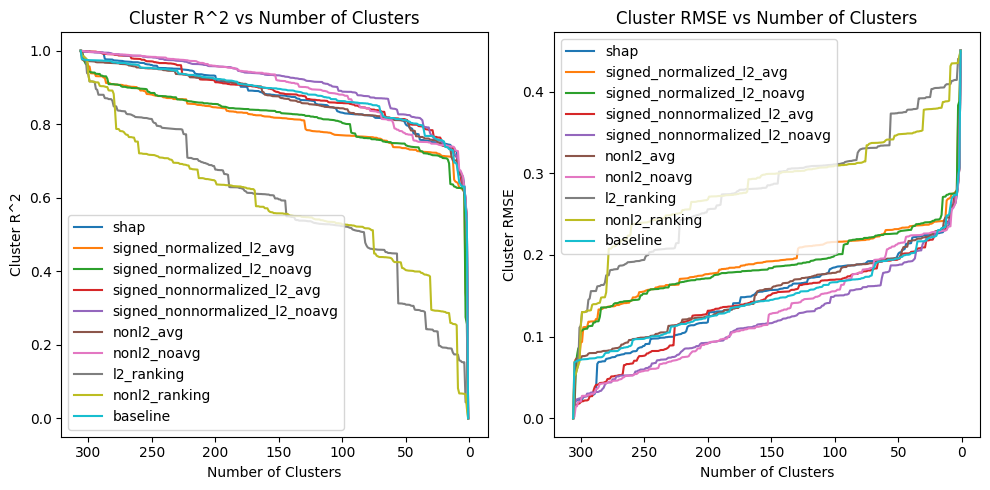

Results for dataset temperature from datasource function with seed 7.


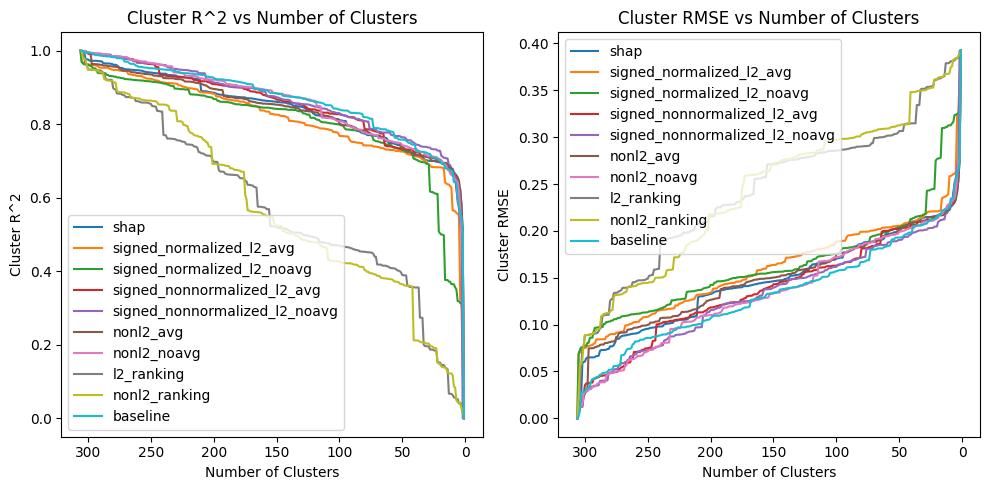

Results for dataset temperature from datasource function with seed 8.


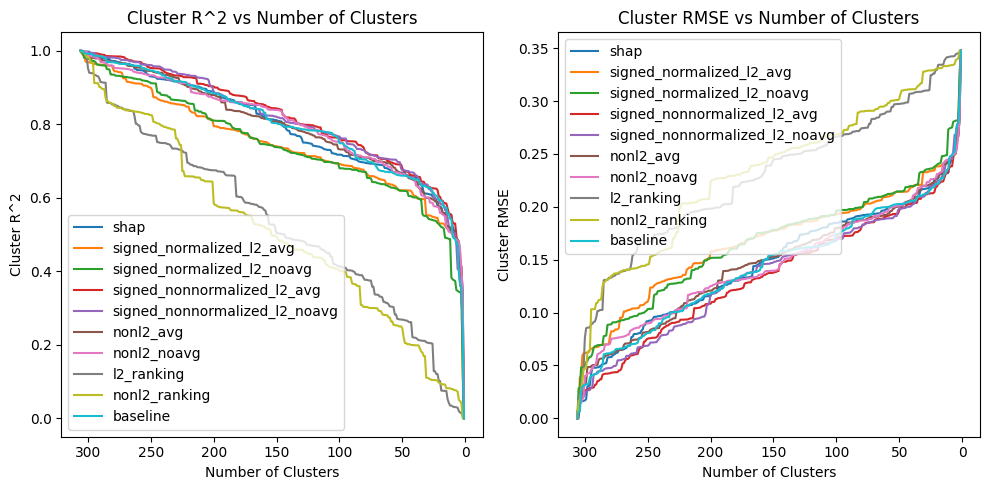

Results for dataset temperature from datasource function with seed 9.


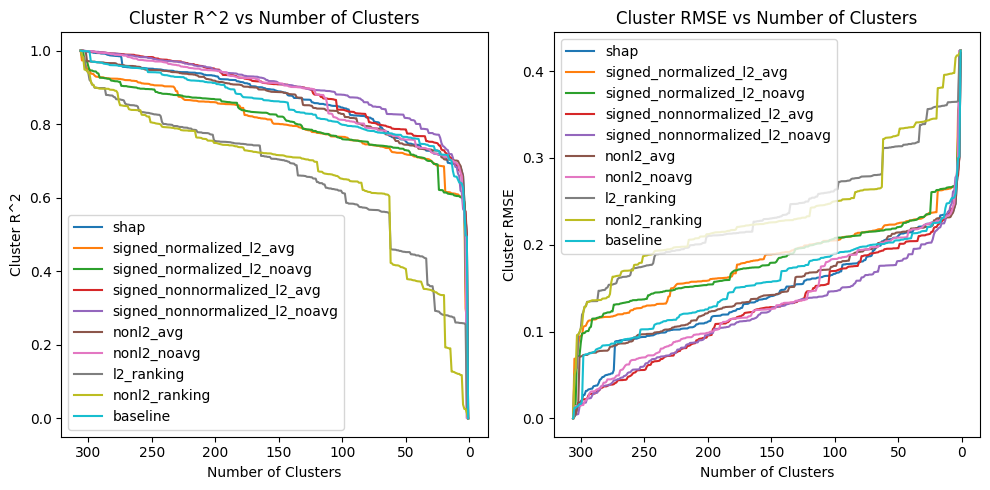

Results for dataset temperature from datasource function with seed 10.


KeyboardInterrupt: 

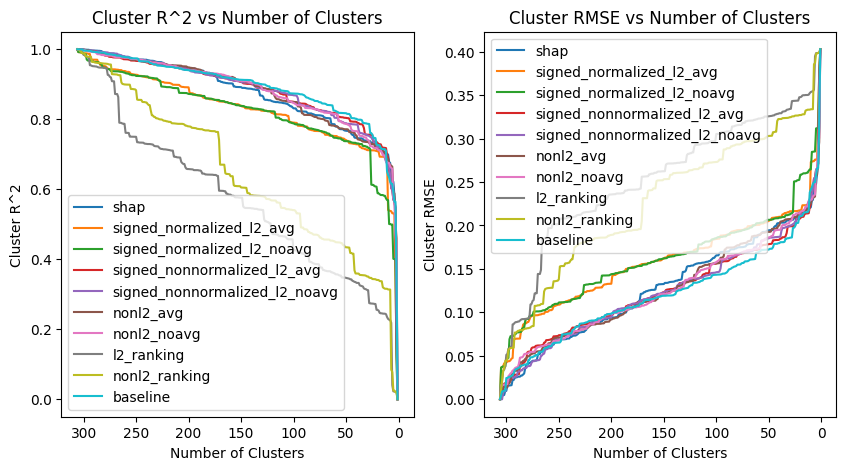

In [15]:
for key, values_dict in values_results.items():
    if task_results[key] == 'classification':
        metrics = ['AUROC', 'AUPRC', 'R^2', 'F1', 'Accuracy']
    else:
        metrics = ['R^2', 'RMSE']
    # print "Results for " + text of key after first underscore
    parts = key.split('_')
    print(f"Results for dataset {parts[1]} from datasource {parts[0]} with seed {parts[-1]}.")
    # create new plot
    if task_results[key] == 'classification':
        height = 15
    else:
        height = 5
    fig, axes = plt.subplots(math.ceil(len(metrics)/2.0), 2, figsize=(10, height))
    axes = axes.flatten()
    plot_count = 0
    for metric in metrics:
        ax = axes[plot_count]
        # plt.figure()
        for method, df in values_dict.items():
            # plt.plot(df['nclust'], df[metric])
            ax.plot(df['nclust'], df[metric])
        ax.legend(list(values_dict.keys()))
        ax.set_xlabel('Number of Clusters')
        ax.set_ylabel('Cluster ' + metric)
        ax.set_title('Cluster ' + metric + ' vs Number of Clusters')
        ax.invert_xaxis()
        plot_count += 1
    plt.tight_layout()
    plt.show()

In [ ]:
for key, rankings_dict in rankings_results.items():
    if task_results[key] == 'classification':
        metrics = ['AUROC', 'AUPRC', 'R^2', 'F1', 'Accuracy']
    else:
        metrics = ['R^2', 'RMSE']
    # print "Results for " + text of key after first underscore
    parts = key.split('_')
    print(f"Results for dataset {parts[1]} from datasource {parts[0]} with seed {parts[-1]}.")
    for p_value in p_values:
        print(f"Results for RBO Matrix with parameter p = {p_value}.")
        # create new plot
        if task_results[key] == 'classification':
            height = 15
        else:
            height = 5
        fig, axes = plt.subplots(math.ceil(len(metrics)/2.0), 2, figsize=(10, height))
        axes = axes.flatten()
        plot_count = 0
        for metric in metrics:
            # create new plot
            ax = axes[plot_count]
            method_list = []
            for method, df in rankings_dict.items():
                if method.endswith(p_value):
                    ax.plot(df['nclust'], df[metric])
                    method_list.append(method)
            ax.legend(method_list)
            ax.set_xlabel('Number of Clusters')
            ax.set_ylabel('Cluster ' + metric)
            ax.set_title('Cluster ' + metric + ' vs Number of Clusters')
            ax.invert_xaxis()
            plot_count += 1
        plt.tight_layout()
        plt.show()